In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import softmax

from src.estimates import get_confidence_estimates
from src.metrics import (
    plot_calibration_curve,
    adaptive_calibration_error,
    brier_score,
    plot_accuracy_rejection_curve
)
from src.utils import plot_accuracy_vs_metric, subsample_answer_options

In [2]:
graphics_path = "../images/pdf/"
tables_path = "../tables/"
list_of_all_models = [
    "bert-base-cased", "bert-large-cased", "gemma-2b", "gemma-7b",
    "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "opt-125m",
    "opt-350m", "opt-1.3b", "opt-6.7b", "roberta-base", "roberta-large",
    "xlm-roberta-base", "xlm-roberta-large"
]

In [3]:
if os.path.isfile("../../scores/BEAR/instance_level_results.json"):
    instance_lvl_results = pd.read_json(
        "../../scores/BEAR/instance_level_results.json",
        orient="records",
        lines=True
    )
else:
    results_list = []
    for model in list_of_all_models:
        predictions = get_confidence_estimates(path="../../scores/BEAR", model=model)
        results_list.append(predictions)
    instance_lvl_results = pd.concat(results_list, ignore_index=True)
    instance_lvl_results.to_json(
        "../../scores/BEAR/instance_level_results.json",
        orient="records",
        lines=True
    )

## Table: Adaptive Calibration Errors & Brier Scores

In [4]:
estimators = [
    "base_conf", "margin_conf", "average_conf_voting_2", 
    "average_conf_min_conf", "consistency_conf_voting_2", "consistency_conf_min_conf"]
evaluation_metrics_per_model = {
    "model": [],
    "estimator": [],
    "accuracy": [],
    "ace": [],
    "brier_score": []
}

for model in list_of_all_models:
    df_model = instance_lvl_results.query("model == @model")

    for estimator in estimators:
        if estimator in ["average_conf_voting_2", "consistency_conf_voting_2"]:
            preds = df_model["voting_2_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["voting_2_correct"].mean())
        elif estimator in ["average_conf_min_conf", "consistency_conf_min_conf"]:
            preds = df_model["min_conf_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["min_conf_correct"].mean())
        else:
            preds = df_model["correctly_predicted"]
            evaluation_metrics_per_model["accuracy"].append(df_model["correctly_predicted"].mean())

        confs = df_model[estimator]

        ace = adaptive_calibration_error(preds, confs, n_bins=20)
        brier = brier_score(preds, confs)
        evaluation_metrics_per_model["model"].append(model)
        evaluation_metrics_per_model["estimator"].append(estimator)
        evaluation_metrics_per_model["ace"].append(ace)
        evaluation_metrics_per_model["brier_score"].append(brier)
results_metrics = pd.DataFrame(evaluation_metrics_per_model)

In [5]:
# Save latex tables
(
    results_metrics
    .pivot_table(index="model", columns="estimator", values="ace")
    .round(3)
    .reindex(columns=estimators)
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(
        tables_path + "ace_per_model.txt",
        float_format="%.3f",
        header=True,
    )
)
(
    results_metrics
    .pivot_table(index="model", columns="estimator", values="brier_score")
    .round(3)
    .reindex(columns=estimators)
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(
        tables_path + "brier_score_per_model.txt",
        float_format="%.3f",
        header=True,
    )
)

## Figure: Calibration Curves of the estimates

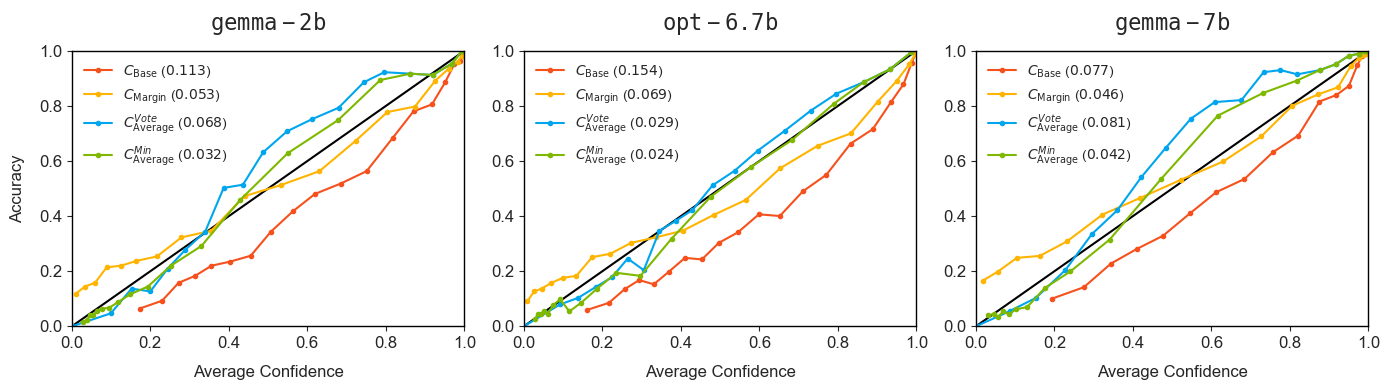

In [6]:
# Data for the models
gemma_2b = instance_lvl_results.query("model == 'gemma-2b'")
opt67 = instance_lvl_results.query("model == 'opt-6.7b'")
gemma_7b = instance_lvl_results.query("model == 'gemma-7b'")

models_info = [
    {
        "title": "gemma-2b",
        "df": gemma_2b,
        "pred_keys": ["correctly_predicted", "correctly_predicted", "voting_2_correct", "min_conf_correct"],
        "conf_keys": ["base_conf", "margin_conf", "average_conf_voting_2", "average_conf_min_conf"],
        "labels": [r"$C_{\text{Base}}$", r"$C_{\text{Margin}}$", r"$C_{\text{Average}}^{Vote}$", r"$C_{\text{Average}}^{Min}$"],
        "ace": [0.113, 0.053, 0.068, 0.032],
        "col": 0
    },
    {
        "title": "opt-6.7b",
        "df": opt67,
        "pred_keys": ["correctly_predicted", "correctly_predicted", "voting_2_correct", "min_conf_correct"],
        "conf_keys": ["base_conf", "margin_conf", "average_conf_voting_2", "average_conf_min_conf"],
        "labels": [r"$C_{\text{Base}}$", r"$C_{\text{Margin}}$", r"$C_{\text{Average}}^{Vote}$", r"$C_{\text{Average}}^{Min}$"],
        "ace": [0.154, 0.069, 0.029, 0.024],
        "col": 1
    },
    {
        "title": "gemma-7b",
        "df": gemma_7b,
        "pred_keys": ["correctly_predicted", "correctly_predicted", "voting_2_correct", "min_conf_correct"],
        "conf_keys": ["base_conf", "margin_conf", "average_conf_voting_2", "average_conf_min_conf"],
        "labels": [r"$C_{\text{Base}}$", r"$C_{\text{Margin}}$", r"$C_{\text{Average}}^{Vote}$", r"$C_{\text{Average}}^{Min}$"],
        "ace": [0.077, 0.046, 0.081, 0.042],
        "col": 2
    }
]

_, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for info in models_info:
    ax = axes[info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*4,
        markers=["."]*4,
        colors=["#f6511d", "#ffb400", "#00a6ed", "#7fb800"],
        title_fontsize=16,
        legend_fontsize=10,
        axes_label_fontsize=12,
        axis=ax,
        n_bins=20
    )
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [
        f"{label} ($\\mathit{{{ace:.3f}}}$)"
        for label, ace in zip(labels, info["ace"])
    ]
    ax.legend(handles, new_labels, frameon=False, fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=12)
    if info["col"] > 0:
        ax.set_ylabel("")
plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_estimates.pdf", format="pdf")
plt.show()

## Figure: Correlation Plot (Accuracy vs. ACE)

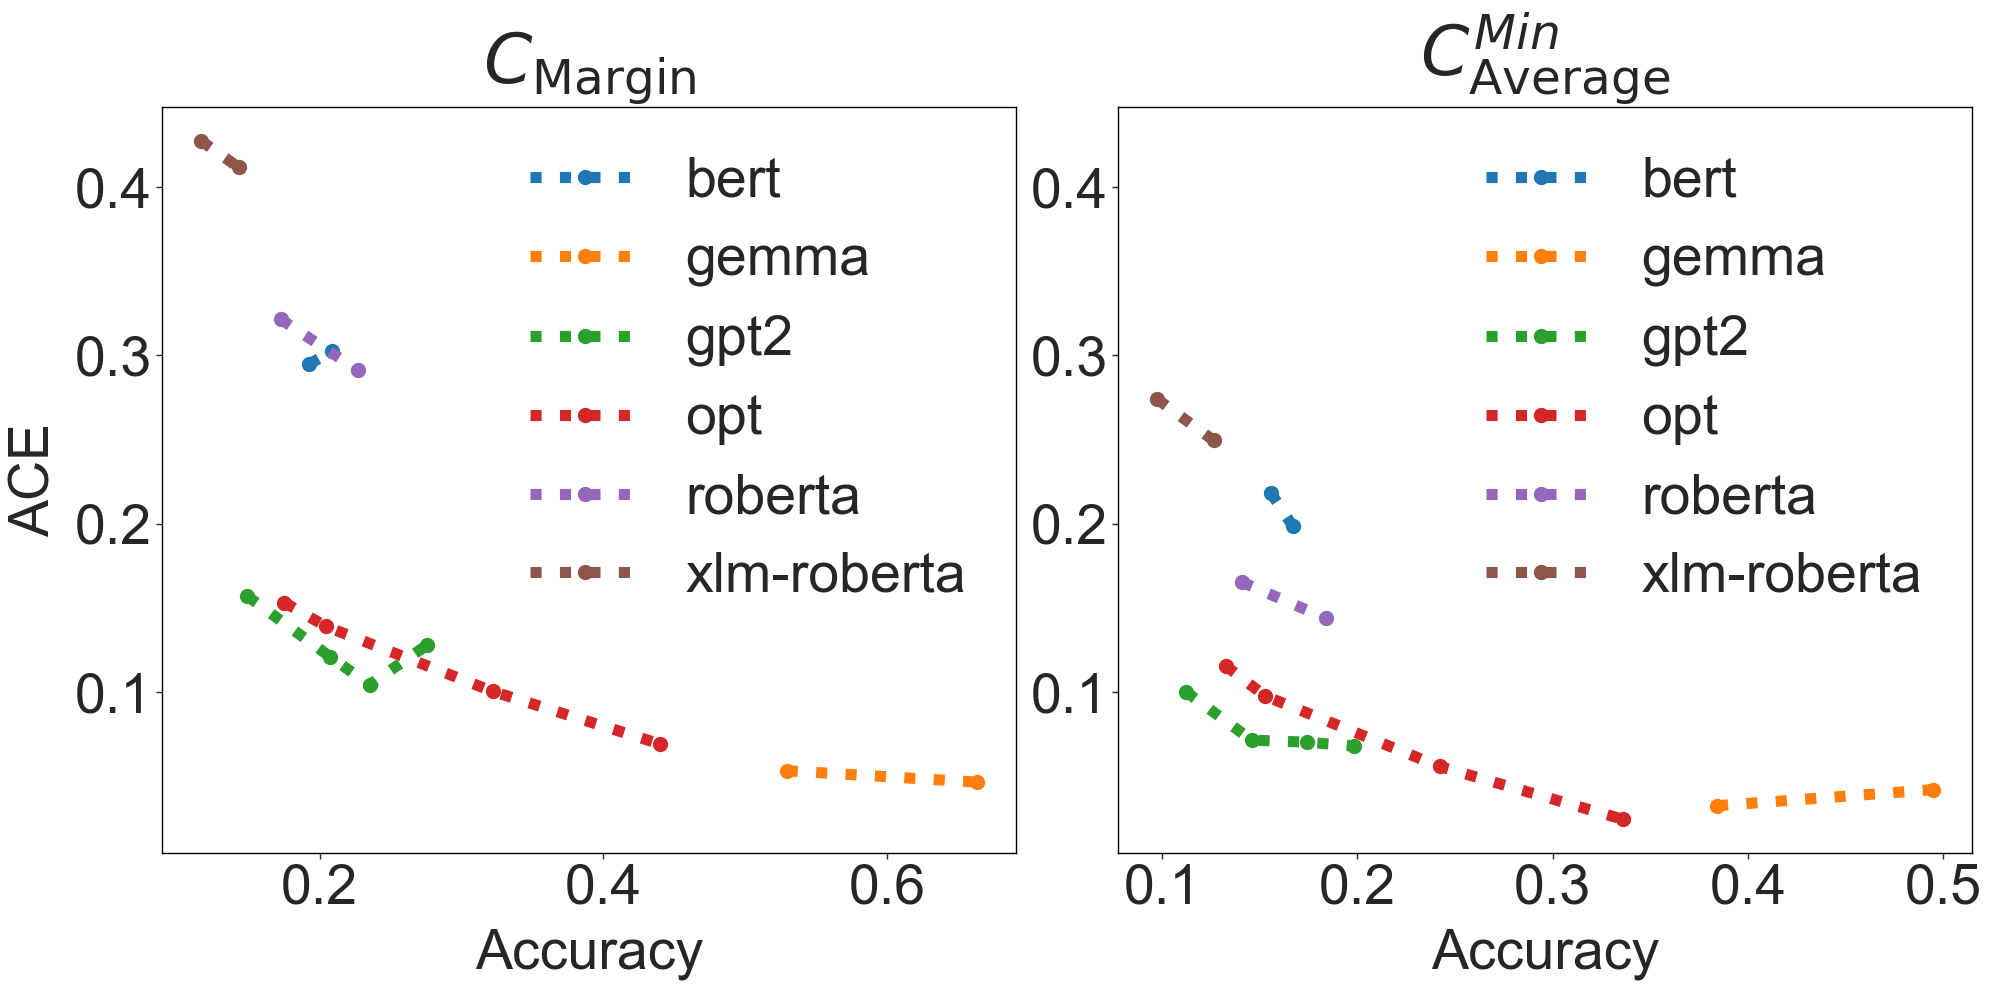

In [7]:
model_families = pd.DataFrame([
    ("bert-base-cased", "bert"),
    ("bert-large-cased", "bert"),
    ("gemma-2b", "gemma"),
    ("gemma-7b", "gemma"),
    ("gpt2", "gpt2"),
    ("gpt2-medium", "gpt2"),
    ("gpt2-large", "gpt2"),
    ("gpt2-xl", "gpt2"),
    ("opt-125m", "opt"),
    ("opt-350m", "opt"),
    ("opt-1.3b", "opt"),
    ("opt-6.7b", "opt"),
    ("roberta-base", "roberta"),
    ("roberta-large", "roberta"),
    ("xlm-roberta-base", "xlm-roberta"),
    ("xlm-roberta-large", "xlm-roberta")],
    columns=["model", "family"]
)
results_evaluation = pd.DataFrame(evaluation_metrics_per_model).merge(
    model_families,
    on="model",
    how="inner"
)

_, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white", sharey=True)

plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="margin_conf",
                        title=r"$C_{\text{Margin}}$", axis=axes[0])
axes[0].set_ylabel("ACE")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="average_conf_min_conf",
                        title=r"$C_{\text{Average}}^{Min}$", axis=axes[1])
axes[1].set_ylabel("")
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=50)
    ax.set_xlabel(ax.get_xlabel(), fontsize=40)
    ax.set_ylabel(ax.get_ylabel(), fontsize=40)
    ax.tick_params(axis="both", which="major", labelsize=40)
    ax.legend(fontsize=40, frameon=False)
plt.tight_layout()
plt.savefig(graphics_path + "accuracy_vs_ace.pdf", format="pdf")
plt.show()

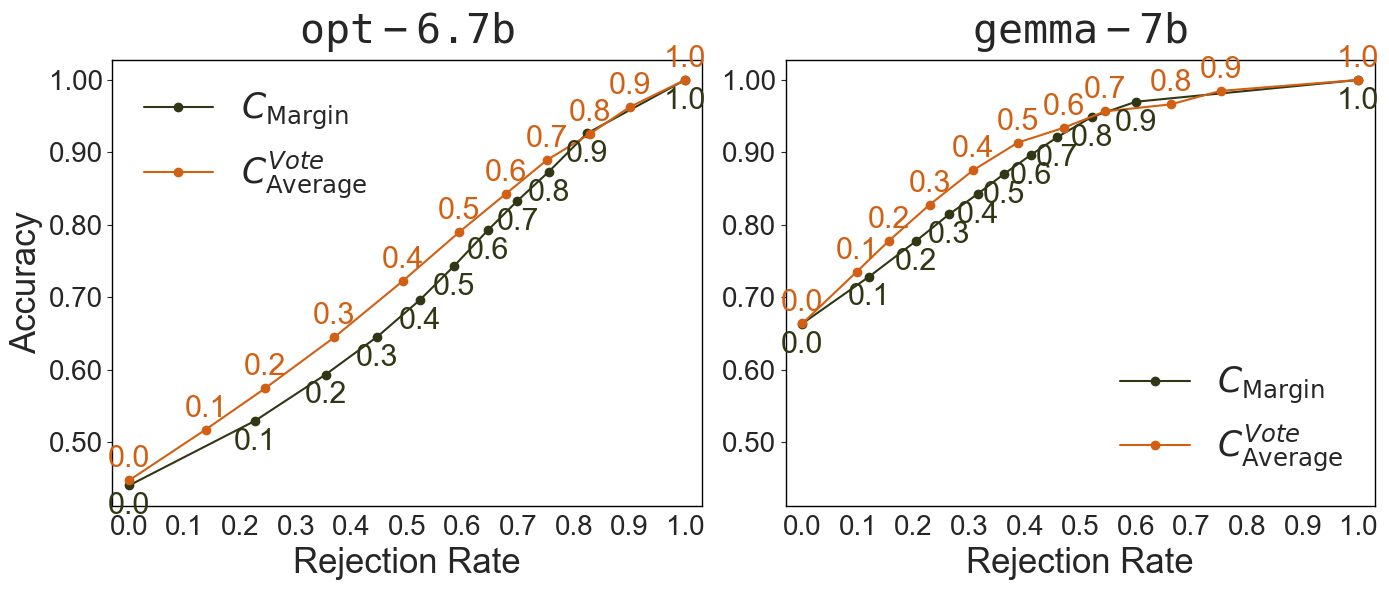

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes = axes.flat
models = ["opt-6.7b", "gemma-7b"]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i, model in enumerate(models):
    df_model = instance_lvl_results.query("model == @model")

    p_m = df_model.correctly_predicted
    c_m = df_model.margin_conf

    p_a = df_model.voting_2_correct
    c_a = df_model.average_conf_voting_2

    plot_accuracy_rejection_curve(
        title=rf"$\mathtt{{{model}}}$",
        predictions=[p_m, p_a],
        confidences=[c_m, c_a],
        thresholds=thresholds,
        labels=[r"$C_{\text{Margin}}$", r"$C_{\text{Average}}^{Vote}$"],
        colors=["#313715", "#d16014"],
        markers="o",
        linestyles="solid",
        axis=axes[i],
        title_fontsize=30,
        legend_fontsize=25,
        axes_label_fontsize=25,
        axes_tick_fontsize=20,
    )

    if i != 0:
        axes[i].set_ylabel("")

    # shift the annotations of the confidence margin a bit downwards
    for txt in axes[i].texts[:len(thresholds)]:
        x, y = txt.get_position()
        txt.set_position((x, y - 10))
        txt.set_verticalalignment("top")
plt.tight_layout()
plt.savefig(graphics_path + "accuracy_rejection_curves.pdf", format="pdf")
plt.show()

## Figure: ACE vs. #Answer Options

In [9]:
num_repeats = 3
sample_sizes = list(range(5, 61, 5))
results = []
confs_dict = {
    "model": [],
    "sample_size": [],
    "repeat": [],
    "preds": [],
    "confs": [],
}

for model in list_of_all_models:
    df = instance_lvl_results.query("model == @model").copy()
    df["number_answer_options"] = df.apply(lambda x: len(x["pll_scores"]), axis=1)
    # do it only for the 1:1 relations
    df = df[df["number_answer_options"] == 60][
        ["relation", "instance", "answer_idx", "pll_scores"]
    ]

    for k in sample_sizes:
        repeat_metrics = []

        for r in range(num_repeats):
            preds = []
            confs = []
            margin_confs = []
            np.random.seed(r)

            for _, row in df.iterrows():
                scores = np.array(row["pll_scores"])
                answer_idx = row["answer_idx"]
                N = len(scores)

                idxs = subsample_answer_options(N, answer_idx, k)

                subsampled_scores = scores[idxs]
                pred_local = np.argmax(subsampled_scores)
                pred_global = idxs[pred_local]
                correct = (pred_global == answer_idx)

                preds.append(correct)

                prob = softmax(subsampled_scores)
                base_conf = np.max(prob)
                margin_conf = np.sort(prob)[::-1][0] - np.sort(prob)[::-1][1] 
                confs.append(base_conf)
                margin_confs.append(margin_conf)

                confs_dict["model"].append(model)
                confs_dict["sample_size"].append(k)
                confs_dict["repeat"].append(r)
                confs_dict["preds"].append(correct)
                confs_dict["confs"].append(base_conf)

            ace = adaptive_calibration_error(preds, confs)
            ace_margin = adaptive_calibration_error(preds, margin_confs)
            accuracy = np.mean(preds)
            avg_conf = np.mean(confs)

            repeat_metrics.append((ace, ace_margin, accuracy, avg_conf))

        # Average across the multiple samples
        mean_ace = np.mean([m[0] for m in repeat_metrics])
        mean_ace_margin = np.mean([m[1] for m in repeat_metrics])
        mean_accuracy = np.mean([m[2] for m in repeat_metrics])
        mean_avg_conf = np.mean([m[3] for m in repeat_metrics])

        results.append({
            "model": model,
            "sample_size": k,
            "ace": mean_ace,
            "ace_margin": mean_ace_margin,
            "accuracy": mean_accuracy,
            "avg_conf": mean_avg_conf
        })

results_df = pd.DataFrame(results)
results_df.to_json("../../scores/FACTOR/bear_sampled_data.json", orient="records", lines=True)

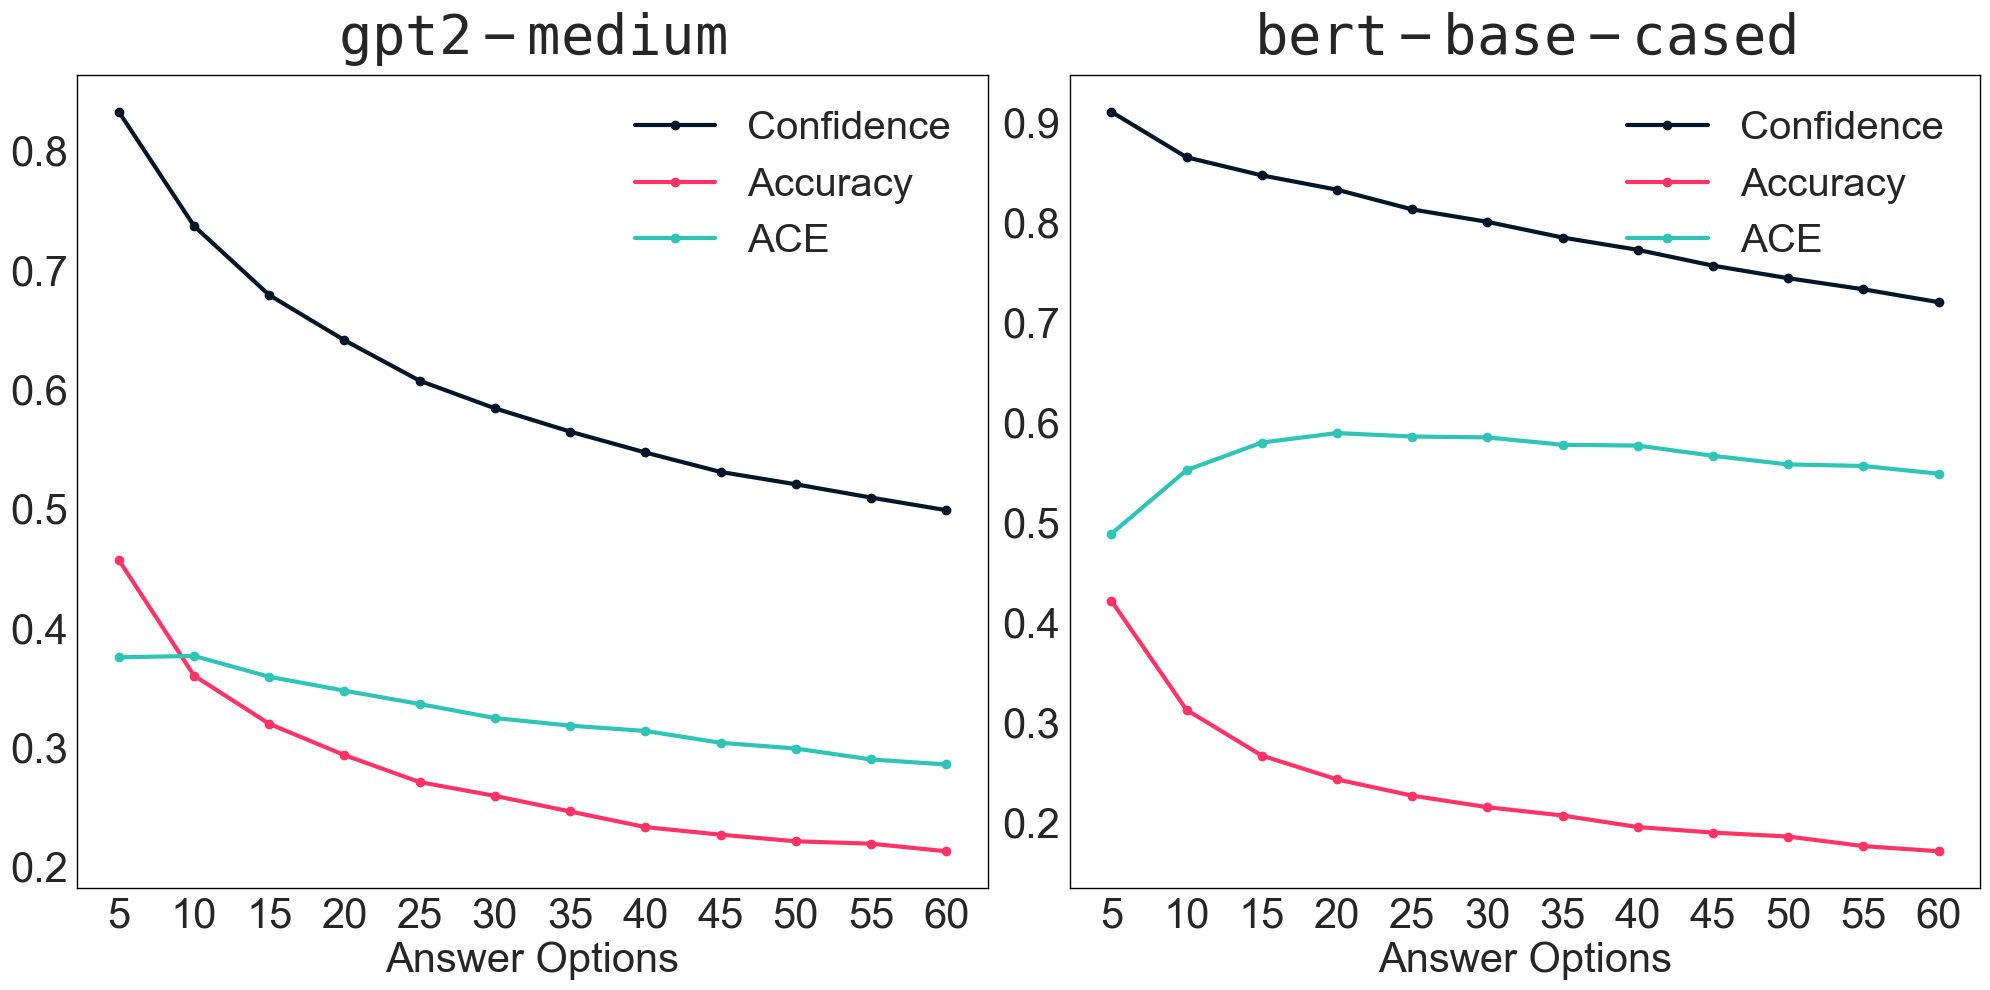

In [10]:
models = ["gpt2-medium", "bert-base-cased"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()

for i, (ax, model) in enumerate(zip(axes, models)):
    model_df = results_df[results_df["model"] == model].sort_values("sample_size")

    # Average Confidence
    ax.plot(
        model_df["sample_size"],
        model_df["avg_conf"],
        marker="o",
        markersize=6,
        linewidth=3,
        label="Confidence",
        color="#011627"
    )
    # Accuracy
    ax.plot(
        model_df["sample_size"],
        model_df["accuracy"],
        marker="o",
        markersize=6,
        linewidth=3,
        label="Accuracy",
        color="#ff3366"
    )
    # ACE
    ax.plot(
        model_df["sample_size"],
        model_df["ace"],
        marker="o",
        markersize=6,
        linewidth=3,
        label="ACE",
        color="#2ec4b6"
    )
    
    ax.set_title(rf"$\mathtt{{{model}}}$", fontsize=40, pad=15)
    ax.set_facecolor("white")
    ax.set_xticks(model_df["sample_size"])
    ax.tick_params(axis="both", which="major", labelsize=30)
    ax.legend(frameon=False, fontsize=29)
    ax.set_xlabel("Answer Options", fontsize=30)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color("black")
plt.tight_layout()
plt.savefig(graphics_path + "metrics_vs_sample_size.pdf", format="pdf")
plt.show()